In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from ramannoodles import spectrafit

In [2]:
# open spectra library
shoyu_data_dict = pickle.load(open('../raman_spectra/shoyu_data_dict.p', 'rb'))
# list keys
sorted(shoyu_data_dict.keys())

['2-PROPANOL',
 'CARBON DIOXIDE',
 'CARBON MONOXIDE',
 'DIMETHYL KETONE',
 'ETHYL ALCOHOL',
 'FORMIC ACID',
 'WATER']

In [3]:
# extract spectra data
data = shoyu_data_dict['WATER']
x_data = data['x']
y_data = data['y']

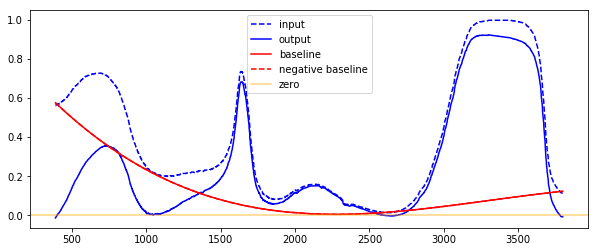

In [4]:
# subtract baseline
y_data = spectrafit.subtract_baseline(y_data, deg=3, plot=True, x_data=x_data)

In [5]:
# detect peaks
peaks, peak_list = spectrafit.peak_detect(x_data, y_data)

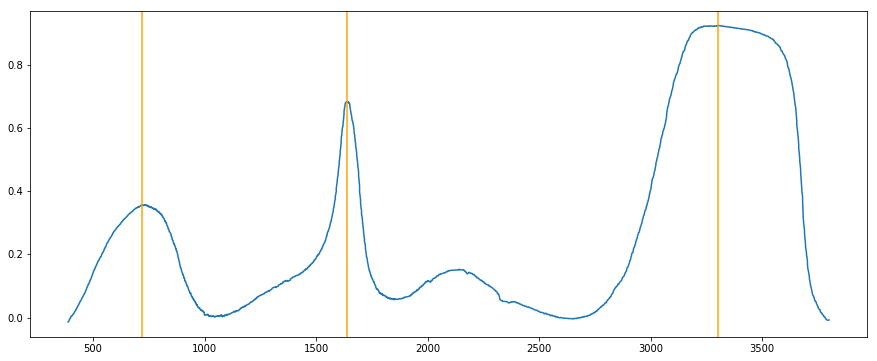

In [6]:
fig = plt.figure(figsize=(15,6))
plt.plot(x_data, y_data)
for i in peak_list[0]:
    plt.axvline(x=x_data[i], color='orange')

In [7]:
# assign parameters for least squares fit
mod, pars = spectrafit.lorentz_params(peaks)

In [8]:
# fit the model to the data
out = spectrafit.model_fit(x_data, y_data, mod, pars, report=True)

[[Model]]
    ((Model(lorentzian, prefix='p1_') + Model(lorentzian, prefix='p2_')) + Model(lorentzian, prefix='p3_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2673
    # data points      = 3917
    # variables        = 12
    chi-square         = 44.5809616
    reduced chi-square = 0.01141638
    Akaike info crit   = -17507.6085
    Bayesian info crit = -17432.3315
[[Variables]]
    p1_sigma:      137.389693 (init = 1)
    p1_center:     711.476523 (init = 720.7402)
    p1_amplitude:  162.247125 (init = 1)
    p1_fwhm:       274.779386 == '2.0000000*p1_sigma'
    p1_height:     0.35659814 (init = 0.3565981)
    p2_sigma:      61.1134159 (init = 1)
    p2_center:     1638.68884 (init = 1640.719)
    p2_amplitude:  125.077122 (init = 1)
    p2_fwhm:       122.226832 == '2.0000000*p2_sigma'
    p2_height:     0.68340290 (init = 0.6834029)
    p3_sigma:      264.796971 (init = 1)
    p3_center:     3312.12318 (init = 3302.123)
    p3_amplitude:  873.1529

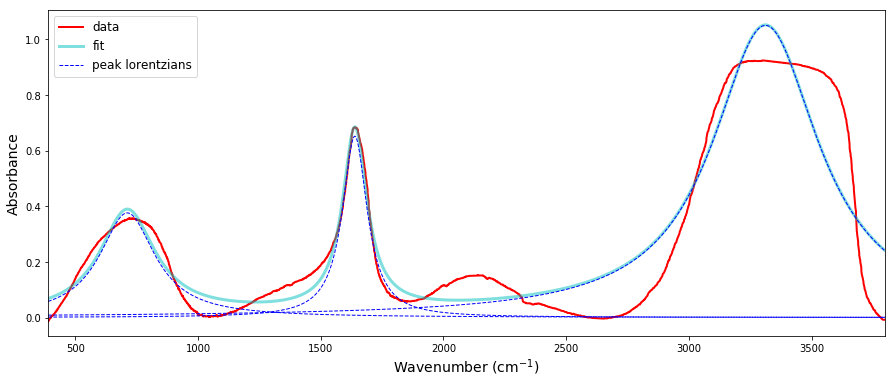

In [9]:
# plot fit results
spectrafit.plot_fit(x_data, y_data, out, plot_components=True)

In [10]:
# export data in logical structure (see docstring)
fit_peak_data = spectrafit.export_fit_data(out)
fit_peak_data

[array([1.37389693e+02, 7.11476523e+02, 1.62247125e+02, 2.74779386e+02,
        3.56598144e-01]),
 array([6.11134159e+01, 1.63868884e+03, 1.25077122e+02, 1.22226832e+02,
        6.83402902e-01]),
 array([2.64796971e+02, 3.31212318e+03, 8.73152939e+02, 5.29593941e+02,
        9.23706182e-01])]

# complete fit wrapper

In [11]:
def compound_report(compound):
    data = shoyu_data_dict[compound]
    x_data = data['x']
    y_data = data['y']
    # subtract baseline
    y_data = spectrafit.subtract_baseline(y_data)
    # detect peaks
    peaks, peak_list = spectrafit.peak_detect(x_data, y_data)
    # assign parameters for least squares fit
    mod, pars = spectrafit.lorentz_params(peaks)
    # fit the model to the data
    out = spectrafit.model_fit(x_data, y_data, mod, pars)
    # export data in logical structure (see docstring)
    fit_peak_data = spectrafit.export_fit_data(out)
    peak_centers = []
    for i in range(len(fit_peak_data)):
        peak_centers.append(fit_peak_data[i][1])
    return peak_centers

In [12]:
peaks = peak_report('CARBON MONOXIDE')

NameError: name 'peak_report' is not defined

In [ ]:
peaks

In [ ]:
def data_report(x_data, y_data):
    # subtract baseline
    y_data = spectrafit.subtract_baseline(y_data)
    # detect peaks
    peaks, peak_list = spectrafit.peak_detect(x_data, y_data)
    # assign parameters for least squares fit
    mod, pars = spectrafit.lorentz_params(peaks)
    # fit the model to the data
    out = spectrafit.model_fit(x_data, y_data, mod, pars)
    # export data in logical structure (see docstring)
    fit_peak_data = spectrafit.export_fit_data(out)
    peak_centers = []
    for i in range(len(fit_peak_data)):
        peak_centers.append(fit_peak_data[i][1])
    return peak_centers